### Flight Fare Prediction Project:
- Credits: MachineHack by Analytics India Magazine
- Data collected from **2019**

<img src="https://res.cloudinary.com/wegowordpress/images/f_auto,q_auto/v1589299940/shutterstock_559714906_auhzh1/shutterstock_559714906_auhzh1.jpg" width=500px></img>
## Where are you departing from? ✈
## Where are you flying to?
## Is it a vacation season? <font color='red'> Worried </font> about the prices?
## This code will predict it for you 😁


<font color='blue'>**Basic imports**

For reading libraries and basic visualizations </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<font color='blue'> **Additional Imports**

As required for ML tasks</font>

In [2]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
train = pd.read_excel('Data_Train.xlsx')
df = train.copy()
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Initial observations:
* **Date_of_Journey** is in a dd/mm/yyyy format
* **Route** is a complex string that needs to be processed
* **Duration** is human-readable which should be converted to minutes
* **Arrival_Time** has ill-formatted data in places which should be addressed

## Step 1: Preprocessing and Feature Engineering
### <font color='darkgreen'> Step 1.1: Processing Dates </font>

- Since the data is only for the year 2019, we can conveniently drop the Date of Journey after processing

In [4]:
df['journey_month'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.month
df['journey_day'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.day
df.drop('Date_of_Journey', axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,3,24
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,3,1


### <font color='darkgreen'> Step 1.2: Processing Times </font>


In [5]:
df['dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['dep_mins'] = pd.to_datetime(df['Dep_Time']).dt.minute 
df['arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['arr_mins'] = pd.to_datetime(df['Arrival_Time']).dt.minute 

# We can now drop the original columns
df.drop(['Dep_Time', 'Arrival_Time'], axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day,dep_hour,dep_mins,arr_hour,arr_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


### <font color='darkgreen'> Step 1.3: Processing Duration </font>

* Simplest approach is to write a custom function to convert to minutes

In [6]:
# To get total duration in minutes
def convert_to_minutes(dur):
    try:
        hr, minute = dur.split(' ')
        hr = int(hr.rstrip('h'))
        minute = int(minute.rstrip('m'))
        total = hr*60+minute
    except:
        if 'h' in dur:
            hr = int(dur.rstrip('h').strip())
            total = hr*60
        else:
            minute = int(dur.rstrip('m').strip())
            total = minute
    return total

In [7]:
# to extract hours of travel from the given Duration format
def get_hours(dur):
    try:
        hr, minute = dur.split(' ')
        hr = int(hr.rstrip('h').strip())
        return hr
    except:
        if 'm' in dur:
            return 0
        else:
            return int(dur.rstrip('h')) 

# to extract minutes of travel from the given Duration format
def get_mins(dur):
    try:
        hr, minute = dur.split(' ')
        minute = int(minute.rstrip('m').strip())
        return minute
    except:
        if 'm' in dur:
            return int(dur.rstrip('m'))
        else:
            return 0
        
df['dur_hours'] = df['Duration'].apply(get_hours)
df['dur_minutes'] = df['Duration'].apply(get_mins)
df['dur_total'] = df['Duration'].apply(convert_to_minutes)

In [8]:
df.drop('Duration', axis=1, inplace=True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_month,journey_day,dep_hour,dep_mins,arr_hour,arr_mins,dur_hours,dur_minutes,dur_total
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,3,24,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45,285


### <font color='darkgreen'> Step 1.4: Processing Airlines </font>

* Check the airlines covered and preprocess accordingly

In [9]:
df['Airline'].value_counts ()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [10]:
# Slightly altering the Airline names for simplicity

df['Airline'] = df['Airline'].replace('Vistara Premium economy','Premium Economy flights')
df['Airline'] = df['Airline'].replace('Multiple carriers Premium economy', 'Premium Economy flights')
df['Airline'] = df['Airline'].replace('Jet Airways Business', 'Business Class Flights')
df = df[df['Airline']!='Trujet']

<Figure size 1440x576 with 0 Axes>

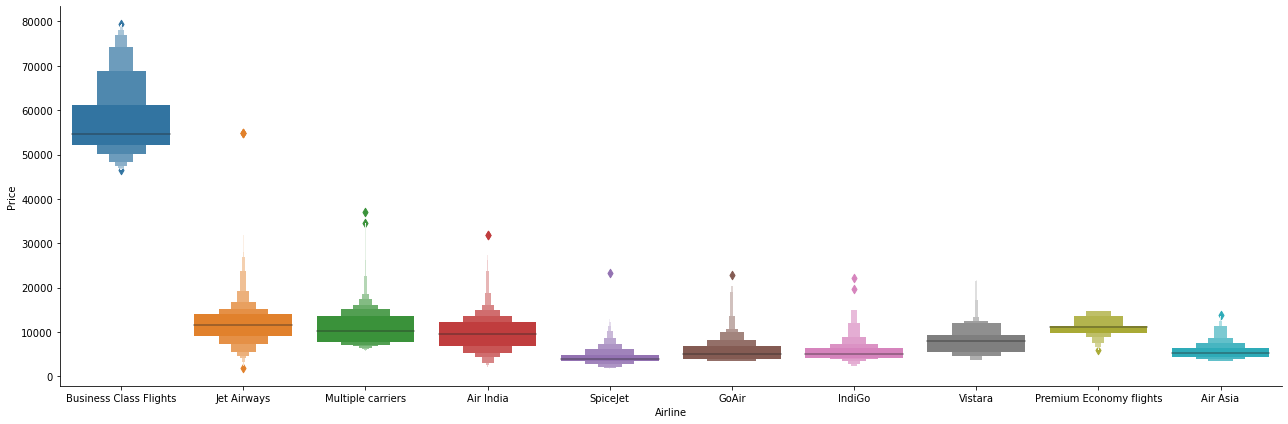

In [11]:
plt.figure(figsize=(20,8))
sns.catplot(y="Price", x="Airline", data=df.sort_values("Price", ascending =False), kind="boxen", height=6, aspect=3)
plt.show()

In [12]:
df['Airline'].value_counts()

Jet Airways                3849
IndiGo                     2053
Air India                  1752
Multiple carriers          1196
SpiceJet                    818
Vistara                     479
Air Asia                    319
GoAir                       194
Premium Economy flights      16
Business Class Flights        6
Name: Airline, dtype: int64

In [13]:
# OneHotEncoding for the Airline names
air = df[['Airline']]
air.columns = ['air']
air_dummy = pd.get_dummies(air, drop_first=True)
air_dummy.head()

,air_Air India,air_Business Class Flights,air_GoAir,air_IndiGo,air_Jet Airways,air_Multiple carriers,air_Premium Economy flights,air_SpiceJet,air_Vistara
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


### <font color='darkgreen'> Step 1.5: Processing Source and Destination Airports </font>

In [14]:
df['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       696
Chennai      381
Name: Source, dtype: int64

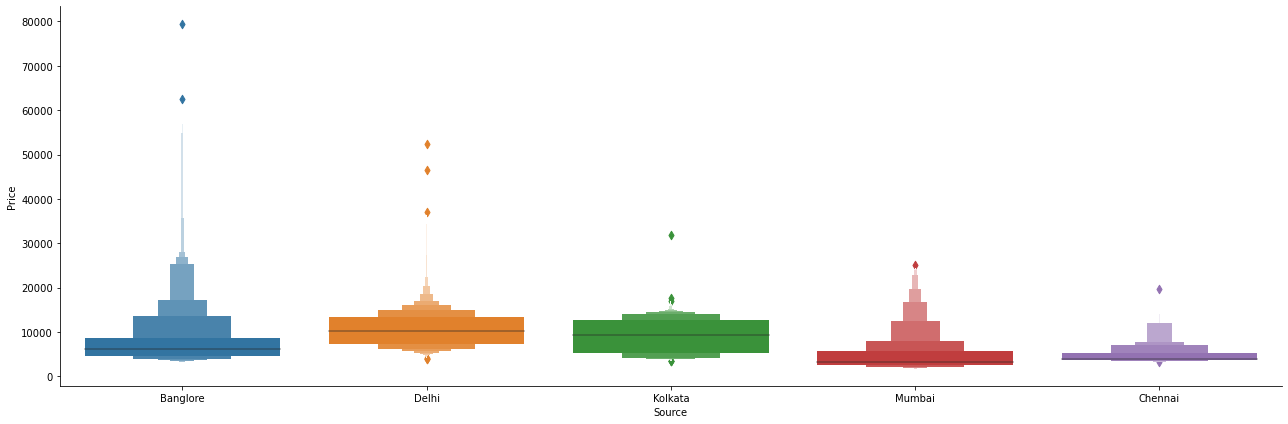

In [15]:
sns.catplot(x="Source", y="Price", data=df.sort_values("Price", ascending =False), kind="boxen", height=6, aspect=3)
plt.show()

In [16]:
df['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     696
Kolkata       381
Name: Destination, dtype: int64

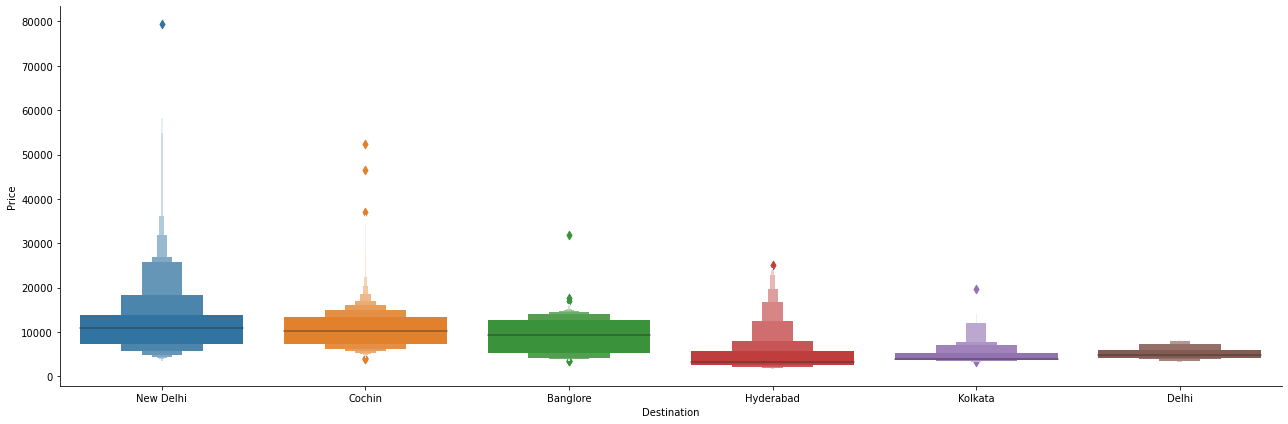

In [17]:
sns.catplot(x='Destination', y="Price", data=df.sort_values("Price", ascending =False), kind="boxen", height=6, aspect=3)
plt.show()

In [18]:
src = df[['Source']]
src.columns = ['src']
src_dummy = pd.get_dummies(src, drop_first=True)
dest = df[['Destination']]
dest.columns = ['dest']
dest_dummy = pd.get_dummies(dest, drop_first=True)
print(src_dummy.shape, dest_dummy.shape)

(10682, 4) (10682, 5)


In [19]:
src_dummy.head()

,src_Chennai,src_Delhi,src_Kolkata,src_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### <font color='darkgreen'> Step 1.6: Processing Route and Additional Info </font>

* Complex string with multiple stops
* Already represented with column **Number of Stops**
* Can conveniently drop these columns

In [20]:
df.drop(['Additional_Info', 'Route'], axis=1, inplace=True)
print(df.shape)

(10682, 14)


### <font color='darkgreen'> Step 1.7: Processing number of stops </font>

* Ordinal data
* Must be encoded to represent the ranking

In [21]:
df['Total_Stops'].value_counts()

1 stop      5624
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [22]:
# Create mapping to represent the hierarchy of this categorical variable
stop_mapping = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}
df['Total_Stops'] = df.Total_Stops.map(stop_mapping)

In [23]:
df = df.convert_dtypes()

In [24]:
df.head(15)

,Airline,Source,Destination,Total_Stops,Price,journey_month,journey_day,dep_hour,dep_mins,arr_hour,arr_mins,dur_hours,dur_minutes,dur_total
0,IndiGo,Banglore,New Delhi,0,3897,3,24,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,2,7662,5,1,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,2,13882,6,9,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,1,6218,5,12,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,1,13302,3,1,16,50,21,35,4,45,285
5,SpiceJet,Kolkata,Banglore,0,3873,6,24,9,0,11,25,2,25,145
6,Jet Airways,Banglore,New Delhi,1,11087,3,12,18,55,10,25,15,30,930
7,Jet Airways,Banglore,New Delhi,1,22270,3,1,8,0,5,5,21,5,1265
8,Jet Airways,Banglore,New Delhi,1,11087,3,12,8,55,10,25,25,30,1530
9,Multiple carriers,Delhi,Cochin,1,8625,5,27,11,25,19,15,7,50,470


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Airline        10682 non-null  string
 1   Source         10682 non-null  string
 2   Destination    10682 non-null  string
 3   Total_Stops    10681 non-null  Int64 
 4   Price          10682 non-null  Int64 
 5   journey_month  10682 non-null  Int64 
 6   journey_day    10682 non-null  Int64 
 7   dep_hour       10682 non-null  Int64 
 8   dep_mins       10682 non-null  Int64 
 9   arr_hour       10682 non-null  Int64 
 10  arr_mins       10682 non-null  Int64 
 11  dur_hours      10682 non-null  Int64 
 12  dur_minutes    10682 non-null  Int64 
 13  dur_total      10682 non-null  Int64 
dtypes: Int64(11), string(3)
memory usage: 1.3 MB


In [26]:
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)

In [27]:
train = pd.concat([df, air_dummy, src_dummy, dest_dummy], axis=1)
train.shape

(10682, 29)

In [28]:
train.to_csv('Airlines_Train.csv', index=False)

In [29]:
train.columns

Index(['Total_Stops', 'Price', 'journey_month', 'journey_day', 'dep_hour',
       'dep_mins', 'arr_hour', 'arr_mins', 'dur_hours', 'dur_minutes',
       'dur_total', 'air_Air India', 'air_Business Class Flights', 'air_GoAir',
       'air_IndiGo', 'air_Jet Airways', 'air_Multiple carriers',
       'air_Premium Economy flights', 'air_SpiceJet', 'air_Vistara',
       'src_Chennai', 'src_Delhi', 'src_Kolkata', 'src_Mumbai', 'dest_Cochin',
       'dest_Delhi', 'dest_Hyderabad', 'dest_Kolkata', 'dest_New Delhi'],
      dtype='object')

### Preprocessing complete

## Step 2: Preparing Test Data to check accuracy 
* Running all preprocessing steps as before
* Remove anomalies if any

In [30]:
TestData = pd.read_excel("Test_set.xlsx")
print(TestData.shape)

(2671, 10)


In [31]:
TestData.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [32]:
def preprocess(df):
    air_test = df[['Airline']]
    
    air_test.loc[:,'Airline'] = air_test['Airline'].replace('Vistara Premium economy','Premium Economy flights')
    air_test.loc[:,'Airline'] = air_test['Airline'].replace('Multiple carriers Premium economy', 'Premium Economy flights')
    air_test.loc[:,'Airline'] = air_test['Airline'].replace('Jet Airways Business', 'Business Class Flights')
    air_test = air_test[air_test['Airline']!='Trujet']
    air_test.columns = ['air']
    air_dummy_test = pd.get_dummies(air_test, drop_first=True)
    
    src_test = df[['Source']]
    src_test.columns=['src']
    src_dummy_test = pd.get_dummies(src_test, drop_first=True)
    
    dest_test = df[['Destination']]
    dest_test.columns = ['dest']
    dest_dummy_test = pd.get_dummies(dest_test, drop_first=True)
    
    df = df.drop(['Airline', 'Source', 'Destination', 'Route', 'Additional_Info'], axis=1)
    
    df['journey_month'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.month
    df['journey_day'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.day
    
    df['dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['dep_mins'] = pd.to_datetime(df['Dep_Time']).dt.minute 
    df['arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['arr_mins'] = pd.to_datetime(df['Arrival_Time']).dt.minute 

    # We can now drop the original columns
    df = df.drop(['Dep_Time', 'Arrival_Time'], axis=1)

    df['dur_hours'] = df['Duration'].apply(get_hours)
    df['dur_minutes'] = df['Duration'].apply(get_mins)
    df['dur_total'] = df['Duration'].apply(convert_to_minutes)
    
    df = df.drop(['Duration','Date_of_Journey'], axis=1)
    
    
    # Create mapping to represent the hierarchy of this categorical variable
    stop_mapping = {
        'non-stop': 0,
        '1 stop': 1,
        '2 stops': 2,
        '3 stops': 3,
        '4 stops': 4
    }
    df['Total_Stops'] = df.Total_Stops.map(stop_mapping)
    
    return pd.concat([df, air_dummy_test, src_dummy_test, dest_dummy_test], axis=1)

In [33]:
test = preprocess(TestData)
test.columns

D:\PyAnaconda\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Index(['Total_Stops', 'journey_month', 'journey_day', 'dep_hour', 'dep_mins',
       'arr_hour', 'arr_mins', 'dur_hours', 'dur_minutes', 'dur_total',
       'air_Air India', 'air_Business Class Flights', 'air_GoAir',
       'air_IndiGo', 'air_Jet Airways', 'air_Multiple carriers',
       'air_Premium Economy flights', 'air_SpiceJet', 'air_Vistara',
       'src_Chennai', 'src_Delhi', 'src_Kolkata', 'src_Mumbai', 'dest_Cochin',
       'dest_Delhi', 'dest_Hyderabad', 'dest_Kolkata', 'dest_New Delhi'],
      dtype='object')

In [34]:
X = train.drop('Price', axis=1)
Y = train['Price']
print(X.shape, Y.shape)

(10682, 28) (10682,)



## Step 3: EDA

In [35]:
df['Total_Stops'].fillna(df['Total_Stops'].median(), inplace=True)
X['Total_Stops'].fillna(X['Total_Stops'].median(), inplace=True)

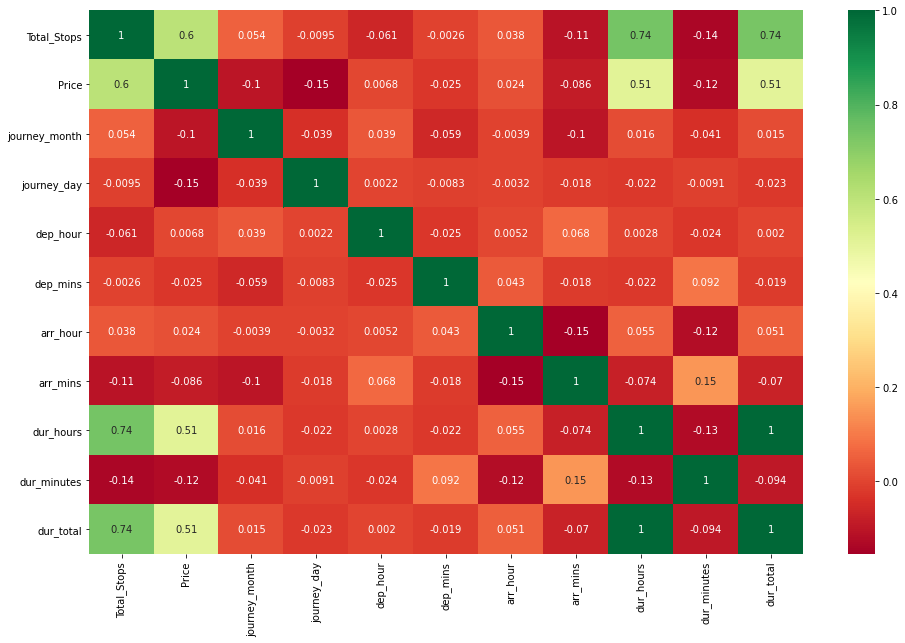

In [36]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

## Step 4: Plot Feature Importances and Fit to Model

In [37]:
select = ExtraTreesRegressor()
select.fit(X,Y)

ExtraTreesRegressor()

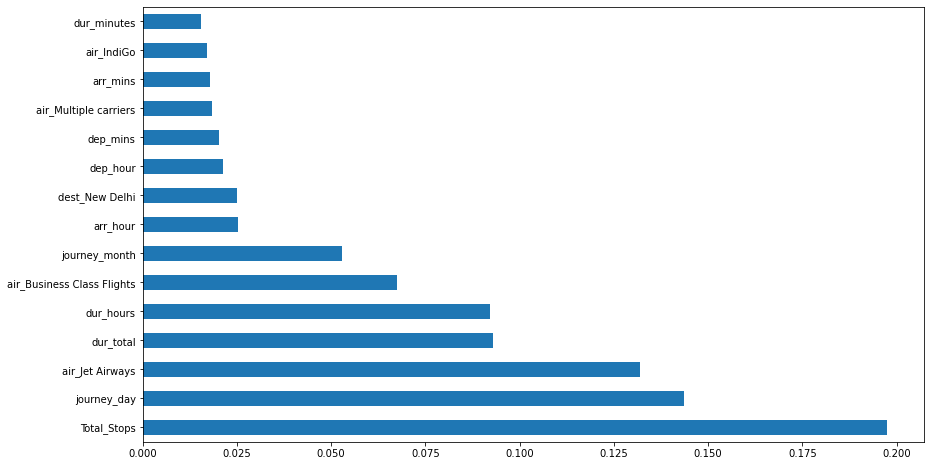

In [38]:
plt.figure(figsize=(14,8))
f_imp = pd.Series(select.feature_importances_, index=X.columns)
f_imp.nlargest(15).plot(kind='barh')
plt.show()

**Split the data**

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=42)
print(xtrain.shape, ytest.shape)

(8545, 28) (2137,)


**Fit to the model**

In [40]:
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)

RandomForestRegressor()

In [41]:
ypreds_rf = rf.predict(xtest)

## Step 5: Evaluate predictions

In [42]:
rf.score(xtrain, ytrain)

0.9541137589698357

In [43]:
rf.score(xtest, ytest)

0.8241298829982169

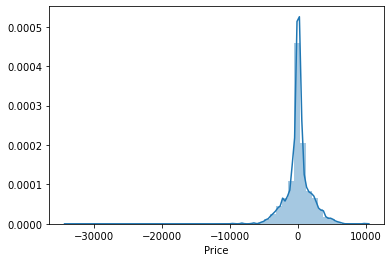

In [44]:
sns.distplot(ypreds_rf - ytest)
plt.show()

Text(0.5, 1.0, 'Scatter Plot of predictions')

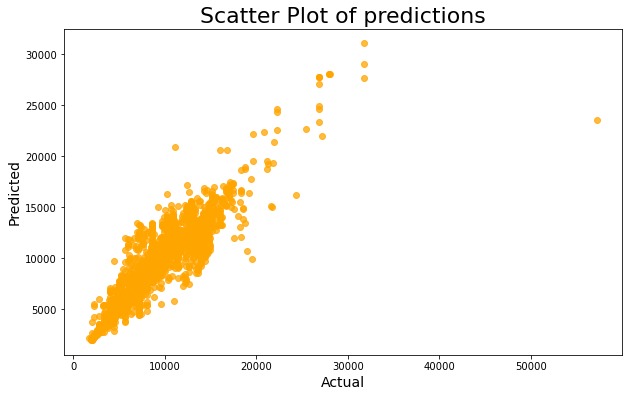

In [45]:
plt.figure(figsize=(10,6))
plt.scatter( ytest, ypreds_rf, color='orange', alpha=0.75)
plt.xlabel("Actual", size=14)
plt.ylabel("Predicted", size=14)
plt.title("Scatter Plot of predictions", size=22)

In [46]:
print(f"MAE: {mean_absolute_error(ytest, ypreds_rf)}")
print(f"MSE: {mean_squared_error(ytest, ypreds_rf)}")
print(f"MAE: {np.sqrt(mean_absolute_error(ytest, ypreds_rf))}")

MAE: 1153.3996461174272
MSE: 3564530.2650203197
MAE: 33.96173797256888


In [47]:
print(f"R-squared score: {r2_score(ytest, ypreds_rf)}")

R-squared score: 0.8241298829982169


## Step 6: Hyperparameter Tuning

* Can improve the fit by using Cross-Validation
    1. Randomized Search
    2. Grid Search
* Assign hyperparameters
* Fit the models
* Evaluate and select the best model

In [48]:
# Generating lists of parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

min_samples_split = [2,5,10,15,50,100]

min_samples_leaf = [1, 2, 5, 10]

In [49]:
rcvgrid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf
          }

In [50]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rcvgrid, scoring='neg_mean_squared_error', n_iter=10, cv=5, verbose=1, n_jobs=1, random_state=420)

In [51]:
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15, 50,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=420, scoring='neg_mean_squared_error',
                   verbose=1)

In [52]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 15,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [53]:
prediction = rf_random.predict(xtest)

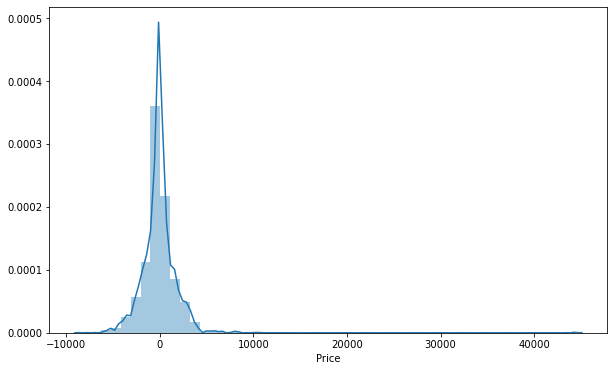

In [54]:
plt.figure(figsize = (10,6))
sns.distplot(ytest-prediction)
plt.show()

In [55]:
import pickle
# open a file, where you ant to store the data
file = open('rf_random.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [56]:
model = open('rf_random.pkl', 'rb')
forest = pickle.load(model)

In [57]:
forest

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15, 50,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=420, scoring='neg_mean_squared_error',
                   verbose=1)

In [58]:
best = forest.best_params_

In [59]:
best

{'n_estimators': 600,
 'min_samples_split': 15,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [60]:
rfinal = RandomForestRegressor()
rfinal.set_params(
    n_estimators = best['n_estimators'],
    max_depth=best['max_depth'],
    min_samples_split = best['min_samples_split'],
    max_features=best['max_features'],
    min_samples_leaf = best['min_samples_leaf'])

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=15,
                      n_estimators=600)

In [61]:
rfinal.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [62]:
rfinal.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=15,
                      n_estimators=600)

In [63]:
yfinal = rfinal.predict(xtest)

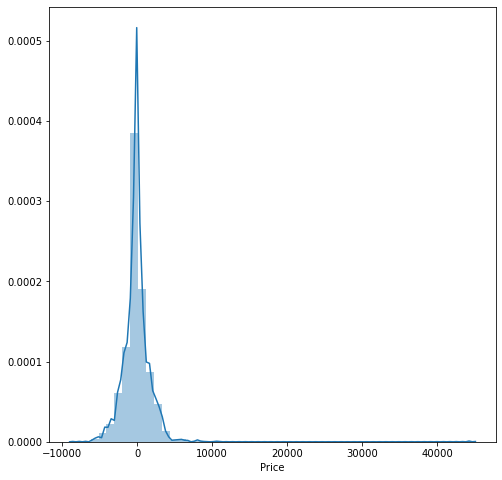

In [64]:
plt.figure(figsize = (8,8))
sns.distplot(ytest-yfinal)
plt.show()

In [65]:
print('MAE:', mean_absolute_error(ytest, yfinal))
print('MSE:', mean_squared_error(ytest, yfinal))
print('RMSE:', np.sqrt(mean_squared_error(ytest, yfinal)))

MAE: 1135.0874329377648
MSE: 3587255.953185652
RMSE: 1894.0052674651283


In [66]:
print(f"R-squared score: {r2_score(ytest, yfinal)}")

R-squared score: 0.8230086218110685


In [67]:
file2 = open('rf_best.pkl', 'wb')
pickle.dump(rfinal, file2)